<a href="https://colab.research.google.com/github/Sobhan-Gh/map-processor/blob/main/dephasing_of_emitter_in_linear_cluster_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An n-qubit entangled state where the 1st qubit is going through dephasing with constant rate /gamma 

In [ ]:
!pip install qutip

In [173]:
from qutip import *
from sympy import Matrix
from qutip.qip.operations import cphase
from qutip.qip.operations import hadamard_transform
from functools import reduce
import numpy as np
from numpy import pi, sqrt
import matplotlib.pyplot as plt

Linear cluster state maker for "n" qubits (ideal case)

In [99]:
def entangler(n):

    #initialize all qubits in |+> state

    qubits_list=[]
    for i in range(n):
        qubit=basis(2,0)
        qubit=hadamard_transform(N=1)*qubit
        qubits_list.append(ket2dm(qubit))
    rho_0=reduce(tensor,qubits_list)

    #entangle through CZ gates for all edges in the cluster to obtain the rho_0 = our initial state for the time evolution

    for i in range(len(qubits_list)-1):
        rho_0=cphase(pi, N=n, control=i, target=i+1)*rho_0*cphase(pi, N=n, control=i, target=i+1).dag()

    return rho_0

Use rho_0 to solve time evolution by Lindbald

In [106]:
# define Hamiltonian
def Hamiltonian(n):
    H0=(2*pi/3.03)*sigmax() #precession time preiod(3.03 ns) by Gershoni's parameters
    H_n=qeye(2)
    H_list=[H0]+[H_n for i in range(n-1)]
    H_total=reduce(tensor,H_list) 
    return H_total

In [133]:
def time_solver(n, gamma_dephase, rho_0, H_total, T=3.03):
    #gamma_dephase = dephasing rate (per cycle?)
    collapse = sqrt(gamma_dephase)*(ket2dm(basis(2,0))-ket2dm(basis(2,1))) #represents dephasing

    collapse_list = [collapse]+[qeye(2) for i in range(n-1)] 
    collapse_total=reduce(tensor,collapse_list) # tensor with other qubits 

    t = np.linspace(0, T, 1000)
    output_list = mesolve(H_total, rho_0, t, collapse_total)
    return output_list

In [134]:
#default time interval is (0,3.03 ns) for one cycle 
def rho_finder(n=2,gamma_dephase=0.01, T=3.03):
    rho_0=entangler(n)
    H_total=Hamiltonian(n)
    final=time_solver(n, gamma_dephase, rho_0, H_total, T)
    return final.states[-1]

In [137]:
# A function to represent QuTiP states in matrix form 
def represent(state):
  x=state.shape[0]
  yyy=Matrix(state.tidyup())
  for i in range(0,x):
    for j in range(0,x):
      yyy[i,j]=round(yyy[i,j],3)
  return yyy


In [158]:
#Evaluate negativity between bi-partitions a and b in the system. 
def eval_negativity(density_matrix,a,b):
  '''In mutipartite state "density_matrix", choose list of qubits in a and b to evaluate negativity for'''
  #counting spaces starting from 0 (the first qubit), 1 (the second) and so on. 
  #note that a and b are lists! In case they only represent one qubit then e.g. a=[0],b=[1,2,3]
  rho=density_matrix.ptrace(a+b)
  ab_list=[0 for x in a]+[1 for y in b]
  rho_pt = partial_transpose(rho,ab_list)
  L = rho_pt.eigenenergies()
  #N = ((rho_pt.dag() * rho_pt).sqrtm().tr().real - 1)/2.0
  N = ((abs(L)-L)/2).sum()
  return round(N,6)

In [170]:
rho=rho_finder(n=2,T=60)
represent(rho)

Matrix([
[            0.25, -0.109 + 0.083*I,            0.075, 0.109 - 0.083*I],
[-0.109 - 0.083*I,             0.25, -0.109 - 0.083*I,          -0.075],
[           0.075, -0.109 + 0.083*I,             0.25, 0.109 - 0.083*I],
[ 0.109 + 0.083*I,           -0.075,  0.109 + 0.083*I,            0.25]])

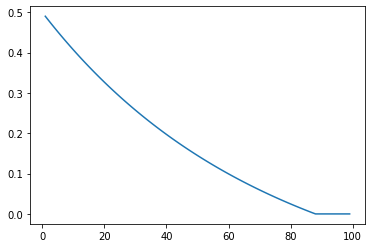

In [179]:
#negativity over time
neg_list=[]
for t in range(1,100):
  rho=rho_finder(n=2,T=t)
  neg_list.append(eval_negativity(rho,[0],[1]))
plt.plot([t for t in range(1,100)],neg_list)
plt.show()